# Loading the dataset

In [137]:
from urllib.request import urlretrieve
import os, ssl

# directory path to store data
output_relative_dir = './data'

# check if it exists as it makedir will raise an error if it does exist
if not os.path.exists(output_relative_dir):
    os.makedirs(output_relative_dir)

In [138]:
YEAR = '2021'
MONTHS = range(6,8)
URL_TEMPLATE = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_"#year-month.parquet

In [139]:
tlc_output_dir = output_relative_dir

for month in MONTHS:
    # 0-fill i.e 1 -> 01, 2 -> 02, etc
    month = str(month).zfill(2) 
    print(f"Begin month {month}")
    
    # generate url
    url = f'{URL_TEMPLATE}{YEAR}-{month}.parquet'
    # generate output location and filename
    output_dir = f"{tlc_output_dir}/{YEAR}-{month}.parquet"

    if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
        ssl._create_default_https_context = ssl._create_unverified_context
    # download
    urlretrieve(url, output_dir) 
    
    print(f"Completed month {month}")

Begin month 06
Completed month 06
Begin month 07
Completed month 07


In [3]:
from pyspark.sql import SparkSession, functions as F

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("ADS")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

22/08/20 22:47:51 WARN Utils: Your hostname, Harshitas-MacBook-Air-8.local resolves to a loopback address: 127.0.0.1; using 192.168.0.227 instead (on interface en0)
22/08/20 22:47:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/20 22:47:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
sdf = spark.read.parquet('./data')

In [5]:
from pyspark.sql import functions as F
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import folium

In [6]:
zones = pd.read_csv("./data/taxi_data/taxi+_zone_lookup.csv")
sf = gpd.read_file("./data/taxi_data/taxi_zones.shp")
# attribute tute code
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

In [7]:
gdf = gpd.GeoDataFrame(pd.merge(zones, sf, on='LocationID', how='inner'))
# create a JSON 
geoJSON = gdf[['LocationID', 'geometry']] \
    .drop_duplicates('LocationID').to_json()

In [8]:
gdf['wkt'] = gdf['geometry'].to_wkt()
gdf['latitude'] = gdf['geometry'].centroid.y
gdf['longitude'] = gdf['geometry'].centroid.x

spark_gdf = spark.createDataFrame(
    gdf[['Zone', 'LocationID', 'wkt', 'latitude', 'longitude']]
)

/var/folders/_2/r25pzjyd1fqfd32_0z2rfzm80000gn/T/ipykernel_2986/4226517316.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['latitude'] = gdf['geometry'].centroid.y
/var/folders/_2/r25pzjyd1fqfd32_0z2rfzm80000gn/T/ipykernel_2986/4226517316.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['longitude'] = gdf['geometry'].centroid.x


In [37]:
import time, math
from datetime import date

DAY_DICT = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 
            4: "Friday", 5: "Saturday", 6: "Sunday"}

def extract_date_time(date_str):
    """
    date string is of the format yyyy-mm-dd hh:mm:ss, e.g., 2022-04-01 00:21:13
    Follows 24-hr time format.
    Return a tuple of the form (time_str, hour_bin, month, date, day, isWeekend)
    """
    date_time = str(date_str).split()

    dateL = list(map(int, date_time[0].split("-")))
    timeL = list(map(int, date_time[1].split(":")))
    
    return dateL, timeL
    

def extract_features(date_str):
    dateL, timeL = extract_date_time(date_str)
    
    time_str = f'{timeL[0]}:{timeL[1]}'
    hour_bin = int(timeL[0])

    dateV = date(dateL[0], dateL[1], dateL[2])

    
    day = DAY_DICT[dateV.weekday()]
    
    is_weekend = 0
    if day in ["Saturday", "Sunday"]:
        is_weekend = 1

    return (time_str, hour_bin, dateV.month, dateV.day, day, is_weekend)

In [10]:
# clean rows with invalid values accoring to the data dictionaries
sdf_clean = sdf.filter(
    (sdf["total_amount"] > 0) &
    (sdf["VendorID"] <= 2) &
    (sdf["VendorID"] >= 1) &
    (sdf["passenger_count"] >= 1) &
    (sdf["trip_distance"] > 0) &
    (sdf["RatecodeID"] <= 6) &
    (sdf["RatecodeID"] >= 1) &
    (sdf["payment_type"] <= 6) &
    (sdf["payment_type"] >= 1)
    )

In [11]:
small_df = sdf_clean.sample(0.05, seed=None)
small_df = small_df.toPandas()

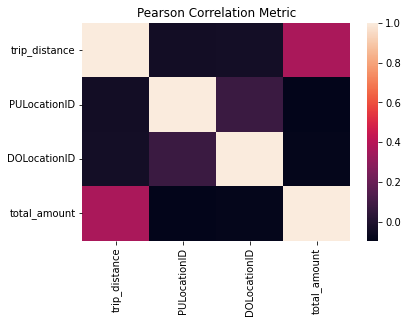

In [12]:
CORR_COLS = ["trip_distance", "PULocationID", "DOLocationID", "total_amount"]
sns.heatmap(small_df[CORR_COLS].corr())

plt.title('Pearson Correlation Metric')
plt.show()

In [13]:
small_df = small_df \
    .merge(gdf[['LocationID', 'geometry']], left_on='PULocationID', right_on='LocationID') \
    .drop('LocationID', axis=1)

In [179]:
# print(sdf_clean.count())
# sdf.count()
sdf.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)



In [53]:
from pyspark.sql.types import ArrayType, FloatType
from pyspark.sql import functions as F

sdf_clean = sdf_clean.withColumn(
    "day_of_year", F.date_format(F.col("tpep_pickup_datetime"), "D"))
sdf_clean = sdf_clean.withColumn(
    "day_of_month", F.date_format(F.col("tpep_pickup_datetime"), "d"))
sdf_clean = sdf_clean.withColumn(
    "day_of_week", F.date_format(F.col("tpep_pickup_datetime"), "E"))
sdf_clean = sdf_clean.withColumn(
    "hour_of_day", F.date_format(F.col("tpep_pickup_datetime"), "H"))
sdf_clean = sdf_clean.withColumn(
    "minute_of_hour", F.date_format(F.col("tpep_pickup_datetime"), "m"))
sdf_clean = sdf_clean.withColumn(
    "is_weekend", 
    F.when(
        (F.col("day_of_week") == "Sat")
        | (F.col("day_of_week") == "Sun"),
        True
    ).otherwise(False))


In [54]:
sdf_clean.limit(5)

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,day_of_year,day_of_month,day_of_week,hour_of_day,minute_of_hour,is_weekend
1,2022-03-01 00:13:08,2022-03-01 00:24:35,1.0,2.4,1.0,N,90,209,2,10.0,3.0,0.5,0.0,0.0,0.3,13.8,2.5,0.0,60,1,Tue,0,13,false
1,2022-03-01 00:47:52,2022-03-01 01:00:08,1.0,2.2,1.0,N,148,234,2,10.5,3.0,0.5,0.0,0.0,0.3,14.3,2.5,0.0,60,1,Tue,0,47,false
2,2022-03-01 00:02:46,2022-03-01 00:46:43,1.0,19.78,2.0,N,132,249,1,52.0,0.0,0.5,11.06,0.0,0.3,67.61,2.5,1.25,60,1,Tue,0,2,false
2,2022-03-01 00:52:43,2022-03-01 01:03:40,2.0,2.94,1.0,N,211,66,1,11.0,0.5,0.5,4.44,0.0,0.3,19.24,2.5,0.0,60,1,Tue,0,52,false
2,2022-03-01 00:15:35,2022-03-01 00:34:13,1.0,8.57,1.0,N,138,197,1,25.0,0.5,0.5,5.51,0.0,0.3,33.06,0.0,1.25,60,1,Tue,0,15,false
